In [10]:
# Install Glide Text2IM package
!pip install git+https://github.com/openai/glide-text2im

  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-wreoz1g0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/glide-text2im /tmp/pip-req-build-wreoz1g0
  Resolved https://github.com/openai/glide-text2im to commit 69b530740eb6cef69442d6180579ef5ba9ef063e
  Preparing metadata (setup.py) ... done


In [11]:
from PIL import Image
from IPython.display import display
import torch as th
from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import create_model_and_diffusion, model_and_diffusion_defaults, model_and_diffusion_defaults_upsampler

In [19]:
# Check for GPU availability
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

# Get system information
system_info = platform.uname()
print(f"System Information:{system_info}")

# Check for GPU availability
if th.cuda.is_available():
    device = th.device('cuda')
    gpu_info = th.cuda.get_device_properties(0)
    print(f"GPU Information:{gpu_info}")
else:
    device = th.device('cpu')
    print("No GPU available. Using CPU.")

# Rest of the code remains the same as provided earlier...


System Information:uname_result(system='Linux', node='8e6e5e24f793', release='6.1.58+', version='#1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023', machine='x86_64')
GPU Information:_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [20]:
# Load base model
options = model_and_diffusion_defaults()
options['use_fp16'] = th.cuda.is_available()
options['timestep_respacing'] = '100'
model, diffusion = create_model_and_diffusion(**options)

model.eval()
if th.cuda.is_available():
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))

<All keys matched successfully>

In [21]:
# Load upsampler model
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = th.cuda.is_available()
options_up['timestep_respacing'] = 'fast27'
model_up, diffusion_up = create_model_and_diffusion(**options_up)

model_up.eval()
if th.cuda.is_available():
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))

<All keys matched successfully>

In [23]:
# Display images function
def show_images(batch):
    scaled = ((batch + 1) * 127.5).round().clamp(0, 255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [24]:
# Text-to-image function
def text_to_image(image_description, batch_size, guidance_scale):
    upsample_temp = 0.997

    tokens = model.tokenizer.encode(image_description)
    tokens, mask = model.tokenizer.padded_tokens_and_mask(tokens, options['text_ctx'])

    full_batch_size = batch_size * 2
    uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask([], options['text_ctx'])

    model_kwargs = dict(
        tokens=th.tensor([tokens] * batch_size + [uncond_tokens] * batch_size, device=device),
        mask=th.tensor([mask] * batch_size + [uncond_mask] * batch_size, dtype=th.bool, device=device),
    )

    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = th.cat([half, half], dim=0)
        model_out = model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
        eps = th.cat([half_eps, half_eps], dim=0)
        return th.cat([eps, rest], dim=1)

    model.del_cache()
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model.del_cache()

    tokens = model_up.tokenizer.encode(image_description)
    tokens, mask = model_up.tokenizer.padded_tokens_and_mask(tokens, options_up['text_ctx'])

    model_kwargs = dict(
        low_res=((samples+1)*127.5).round()/127.5 - 1,
        tokens=th.tensor([tokens] * batch_size, device=device),
        mask=th.tensor([mask] * batch_size, dtype=th.bool, device=device),
    )

    model_up.del_cache()
    up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
    image = diffusion_up.ddim_sample_loop(
        model_up,
        up_shape,
        noise=th.randn(up_shape, device=device) * upsample_temp,
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
    model_up.del_cache()

    show_images(image)
    return image

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

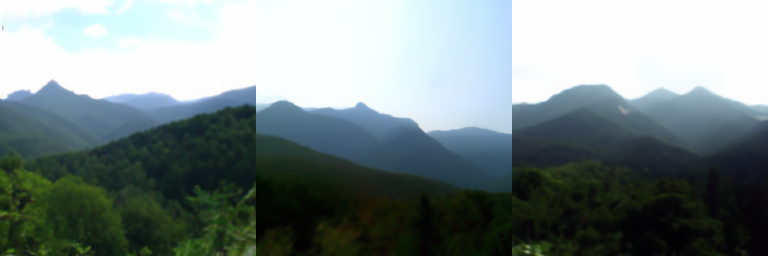

tensor([[[[ 0.9983,  0.9994,  0.9959,  ...,  0.9747,  0.9720,  0.9724],
          [ 0.9999,  0.9980,  1.0000,  ...,  0.9878,  0.9849,  0.9823],
          [ 0.9955,  1.0000,  1.0000,  ...,  0.9876,  0.9877,  0.9903],
          ...,
          [-0.8137, -0.7751, -0.7302,  ..., -0.3002, -0.3328, -0.3587],
          [-0.7827, -0.7304, -0.6794,  ..., -0.3245, -0.3777, -0.4179],
          [-0.7081, -0.6258, -0.5573,  ..., -0.3460, -0.4153, -0.4575]],

         [[ 0.9933,  1.0000,  0.9950,  ...,  0.9899,  0.9898,  0.9854],
          [ 0.9914,  0.9934,  1.0000,  ...,  0.9899,  0.9895,  0.9934],
          [ 0.9950,  0.9959,  0.9923,  ...,  0.9909,  0.9966,  0.9896],
          ...,
          [-0.7200, -0.6685, -0.6046,  ..., -0.0978, -0.1186, -0.1432],
          [-0.6978, -0.6362, -0.5606,  ..., -0.1225, -0.1565, -0.1780],
          [-0.6076, -0.5198, -0.4384,  ..., -0.1437, -0.1836, -0.2161]],

         [[ 0.9938,  1.0000,  0.9994,  ...,  0.9988,  0.9991,  0.9893],
          [ 0.9971,  0.9975,  

In [27]:
#@title Generate the images
input_prompt = "Scenery of Mountains, 4k"#@param
batch_size = 3#@param
guidance_scale = 10.0#@param
text_to_image(input_prompt, batch_size, guidance_scale)
